In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

os.chdir("/Users/nsy/Documents/Grad2/5671/project")
training_features = pd.read_csv("training_features.csv",header =0)
training_labels = pd.read_csv("training_labels.csv",header =0)
testing = pd.read_csv("test_features.csv",header =0)
training = pd.concat([training_features,training_labels],axis = 1)

In [2]:
#data exploration

In [3]:
training.head()

,trans_date,house_age,distance_mrt,stores,latitude,longitude,house_price
0,2013.500000,26.4,335.52730,6,24.97960,121.54140,38.1
1,2013.416667,6.4,90.45606,9,24.97433,121.54310,59.5
2,2013.333333,3.9,49.66105,8,24.95836,121.53756,56.8
3,2013.500000,23.0,3947.94500,0,24.94783,121.50243,25.3
4,2013.333333,39.7,333.36790,9,24.98016,121.53932,32.4


In [4]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 7 columns):
trans_date      289 non-null float64
house_age       289 non-null float64
distance_mrt    289 non-null float64
stores          289 non-null int64
latitude        289 non-null float64
longitude       289 non-null float64
house_price     289 non-null float64
dtypes: float64(6), int64(1)
memory usage: 15.9 KB


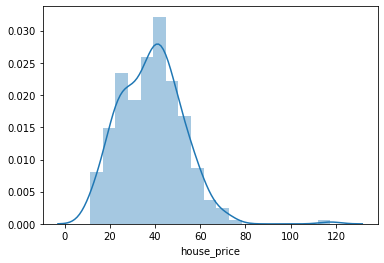

In [5]:
#histogram
sns.distplot(training['house_price'])

In [6]:
#skewness and kurtosis
print("Skewness: %f" % training['house_price'].skew())
print("Kurtosis: %f" % training['house_price'].kurt())

Skewness: 0.706869
Kurtosis: 2.779956


In [7]:
#standardizing data
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
saleprice_scaled = StandardScaler().fit_transform(training['house_price'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.96614126]
 [-1.93715625]
 [-1.89367874]
 [-1.85020123]
 [-1.85020123]
 [-1.83570873]
 [-1.80672372]
 [-1.77773872]
 [-1.71252245]
 [-1.66179869]]

outer range (high) of the distribution:
[[1.78017085]
 [1.8019096 ]
 [1.80915586]
 [1.80915586]
 [2.12799093]
 [2.27291596]
 [2.30190097]
 [2.36711723]
 [2.55551978]
 [5.73662426]]


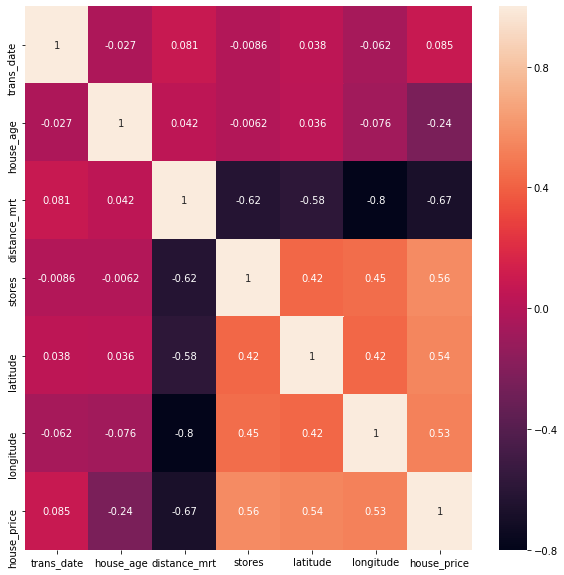

In [8]:
#correlation matrix
%matplotlib inline
corr = training.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr,annot = True,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

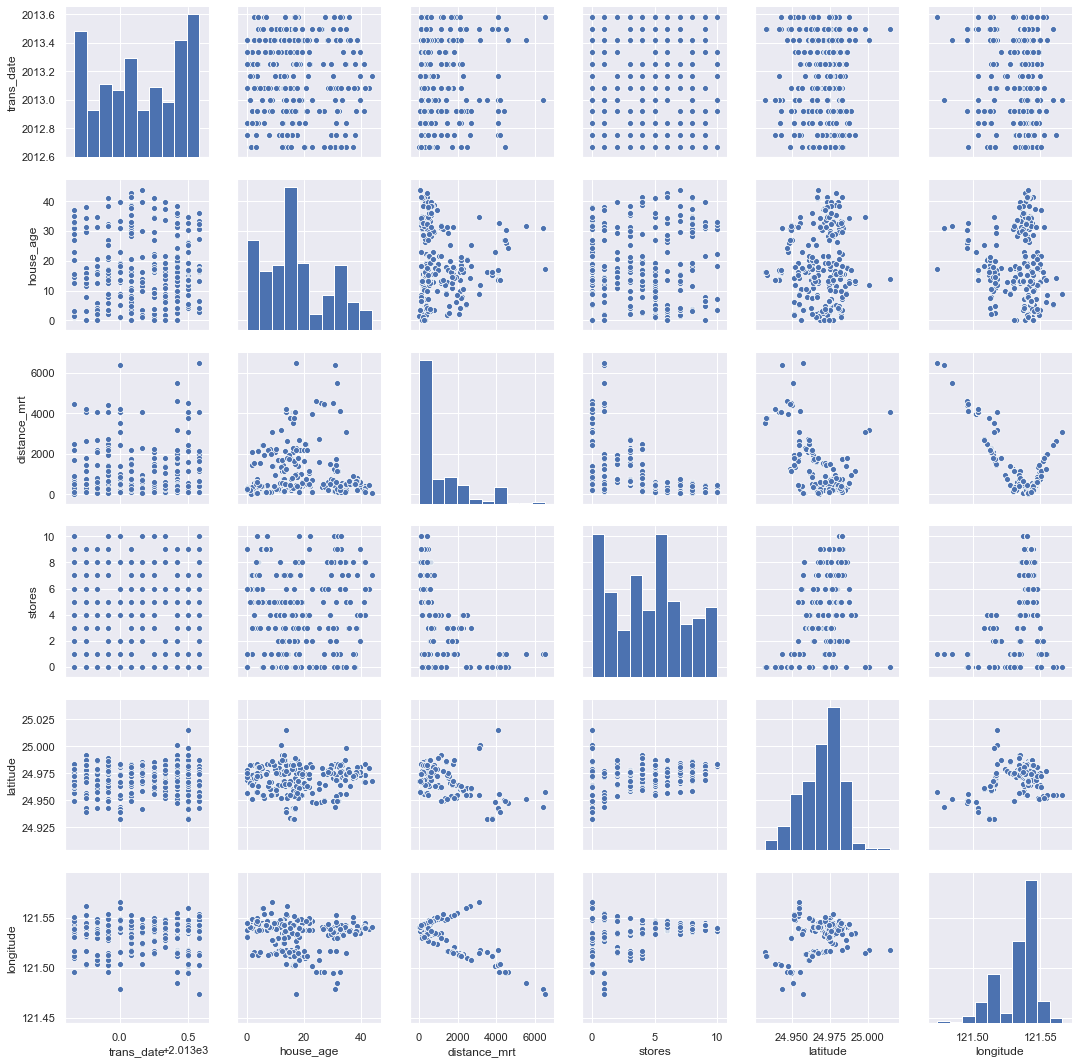

In [9]:
#scatterplot
sns.set()
cols = ['trans_date','house_age','distance_mrt','stores','latitude','longitude']
sns.pairplot(training[cols])
plt.show()

In [10]:
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
conf = SparkConf().setAppName("MLlib")
sc = SparkContext(conf=conf)
sc.setLogLevel("WARN")
spark = SparkSession(sc)

In [11]:
df = spark.createDataFrame(training)
df1 = spark.createDataFrame(testing)
df.show(5)

+------------+---------+------------+------+--------+------------------+-----------+
|  trans_date|house_age|distance_mrt|stores|latitude|         longitude|house_price|
+------------+---------+------------+------+--------+------------------+-----------+
|      2013.5|     26.4|    335.5273|     6| 24.9796|          121.5414|       38.1|
|2013.4166667|      6.4|    90.45606|     9|24.97433|          121.5431|       59.5|
|2013.3333333|      3.9|    49.66105|     8|24.95836|121.53756000000001|       56.8|
|      2013.5|     23.0|    3947.945|     0|24.94783|         121.50243|       25.3|
|2013.3333333|     39.7|    333.3679|     9|24.98016|121.53931999999999|       32.4|
+------------+---------+------------+------+--------+------------------+-----------+
only showing top 5 rows



In [12]:
df.describe().show()

+-------+-------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+
|summary|         trans_date|         house_age|      distance_mrt|            stores|           latitude|          longitude|       house_price|
+-------+-------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+
|  count|                289|               289|               289|               289|                289|                289|               289|
|   mean| 2013.1496539809689|17.356747404844292|1106.0805898961942| 4.041522491349481|  24.96905667820069| 121.53311024221453|38.333217993079586|
| stddev|0.28238176482398636|11.335506737460038| 1270.742433103357|2.9199396695773614|0.01283322943830661|0.01530087586942814|13.824176325079817|
|    min|       2012.6666667|               0.0|23.382839999999998|                 0|           24.93207| 121.4735300000000

In [13]:
#vectorize features
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['trans_date', 'house_age', 'distance_mrt', 'stores', 'latitude', 'longitude'], outputCol = 'features')
vdf = vectorAssembler.transform(df)
vdf = vdf.select(['features', 'house_price'])
vdf1 = vectorAssembler.transform(df1).select(['features'])
vdf.show(3)

+--------------------+-----------+
|            features|house_price|
+--------------------+-----------+
|[2013.5,26.4,335....|       38.1|
|[2013.4166667,6.4...|       59.5|
|[2013.3333333,3.9...|       56.8|
+--------------------+-----------+
only showing top 3 rows



In [14]:
#split the data into training and testing samples
splits = vdf.randomSplit([0.75, 0.25])
vdf = splits[0]
vdft = splits[1]

In [15]:
#Linear Regression

In [18]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='house_price', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(vdf)
training_result = lr_model.summary
print("Root Mean Squared Error (RMSE) on training data: %f" % training_result.rootMeanSquaredError)
testing_result = lr_model.evaluate(vdft)
print("Root Mean Squared Error (RMSE) on testing data = %g" % testing_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on training data: 8.984219
Root Mean Squared Error (RMSE) on testing data = 9.00113


In [ ]:
#Decision Tree

In [20]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'house_price')
dt_model = dt.fit(vdf)
dt_evaluator = RegressionEvaluator(
    labelCol="house_price", predictionCol="prediction", metricName="rmse")
training_result = dt_evaluator.evaluate(dt_model.transform(vdf))
testing_result = dt_evaluator.evaluate(dt_model.transform(vdft))
print("Root Mean Squared Error (RMSE) on training data = %g" % training_result)
print("Root Mean Squared Error (RMSE) on testing data = %g" % testing_result)

Root Mean Squared Error (RMSE) on training data = 5.93585
Root Mean Squared Error (RMSE) on testing data = 9.45724


In [ ]:
#Gradient-Boosting

In [21]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'house_price', maxIter=10)
gbt_model = gbt.fit(vdf)
gbt_evaluator = RegressionEvaluator(
    labelCol="house_price", predictionCol="prediction", metricName="rmse")
training_result = gbt_evaluator.evaluate(gbt_model.transform(vdf))
testing_result = gbt_evaluator.evaluate(gbt_model.transform(vdft))
print("Root Mean Squared Error (RMSE) on training data = %g" % training_result)
print("Root Mean Squared Error (RMSE) on testing data = %g" % testing_result)

Root Mean Squared Error (RMSE) on training data = 3.06569
Root Mean Squared Error (RMSE) on testing data = 10.6786


In [ ]:
#RandomForest

In [24]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol ='features', labelCol = 'house_price')
rf_model = rf.fit(vdf)
rf_evaluator = RegressionEvaluator(
    labelCol="house_price", predictionCol="prediction", metricName="rmse")
training_result = rf_evaluator.evaluate(rf_model.transform(vdf))
testing_result = rf_evaluator.evaluate(rf_model.transform(vdft))
print("Root Mean Squared Error (RMSE) on training data = %g" % training_result)
print("Root Mean Squared Error (RMSE) on testing data = %g" % testing_result)

Root Mean Squared Error (RMSE) on training data = 5.70616
Root Mean Squared Error (RMSE) on testing data = 7.10595


In [25]:
#submit the rf prediction
rf_predictions = rf_model.transform(vdf1).select("prediction")
test = rf_predictions.toPandas()
test.to_csv("/Users/nsy/Documents/Grad2/5671/project/rf.csv",index = True)